In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import socket, struct

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss

In [2]:
nRowsRead = 500000 # specify 'None' if want to read whole file
# Dataset-Unicauca-Version2-87Atts.csv has 3577296 rows in reality, but we are only loading/previewing the first 500 000 rows
# change the path to where the file Dataset-Unicauca-Version2-87Atts.csv is in the local
df =  pd.read_csv (r'C:\Users\Pc\Downloads\ENSEEIHT_etudes\Annee_3\Projet_long\classification_machine_learning\datas\Dataset-Unicauca-Version2-87Atts.csv', delimiter=',', nrows = nRowsRead)
df.dataframeName = 'Dataset-Unicauca-Version2-87Atts.csv'
nRow, nCol = df.shape

print(f'There are {nRow} rows and {nCol} columns')

There are 500000 rows and 87 columns


In [3]:
df.head()

,Flow.ID,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,...,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,Label,L7Protocol,ProtocolName
0,172.19.1.46-10.200.7.7-52422-3128-6,172.19.1.46,52422,10.200.7.7,3128,6,26/04/201711:11:17,45523,22,55,...,0.0,0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
1,172.19.1.46-10.200.7.7-52422-3128-6,10.200.7.7,3128,172.19.1.46,52422,6,26/04/201711:11:17,1,2,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY
2,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,1,3,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
3,10.200.7.217-50.31.185.39-38848-80-6,50.31.185.39,80,10.200.7.217,38848,6,26/04/201711:11:17,217,1,3,...,0.0,0,0.0,0.0,0.0,0.0,0.0,BENIGN,7,HTTP
4,192.168.72.43-10.200.7.7-55961-3128-6,192.168.72.43,55961,10.200.7.7,3128,6,26/04/201711:11:17,78068,5,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,BENIGN,131,HTTP_PROXY


In [4]:
# Function that changes IP addresses into numbers

def ip2int(ip):
    packedIP = socket.inet_aton(ip)
    return struct.unpack("!L", packedIP)[0]

In [5]:
# Converting IP addresses into numbers
df['Source.IP'] = df['Source.IP'].apply(ip2int)
df['Destination.IP'] = df['Destination.IP'].apply(ip2int)

In [6]:
# Checking if any value in the dataframe is null
df.isnull().values.any()

False

In [7]:
# Checking types of values
print(df.dtypes)

Flow.ID              object
Source.IP             int64
Source.Port           int64
Destination.IP        int64
Destination.Port      int64
                     ...   
Idle.Max            float64
Idle.Min            float64
Label                object
L7Protocol            int64
ProtocolName         object
Length: 87, dtype: object


In [8]:
# Checking columns that have only one unique value
df.columns[df.nunique() <= 1]

Index(['Bwd.PSH.Flags', 'Fwd.URG.Flags', 'Bwd.URG.Flags', 'CWE.Flag.Count',
       'Fwd.Avg.Bytes.Bulk', 'Fwd.Avg.Packets.Bulk', 'Fwd.Avg.Bulk.Rate',
       'Bwd.Avg.Bytes.Bulk', 'Bwd.Avg.Packets.Bulk', 'Bwd.Avg.Bulk.Rate',
       'Label'],
      dtype='object')

In [9]:
# Checking occurance of each application
df['ProtocolName'].value_counts()

GOOGLE               125059
HTTP                 111493
HTTP_PROXY            69216
SSL                   67804
HTTP_CONNECT          46807
YOUTUBE               22297
MICROSOFT             10693
AMAZON                 8099
WINDOWS_UPDATE         6683
GMAIL                  4456
SKYPE                  3916
FACEBOOK               3588
YAHOO                  3462
DROPBOX                3247
TWITTER                2635
CLOUDFLARE             2505
MSN                    1842
APPLE                  1567
OFFICE_365              738
WIKIPEDIA               546
CONTENT_FLASH           433
WHATSAPP                408
MS_ONE_DRIVE            393
NETFLIX                 374
IP_ICMP                 259
APPLE_ITUNES            209
DNS                     189
APPLE_ICLOUD            185
INSTAGRAM               158
SSL_NO_CERT             130
EBAY                    101
HTTP_DOWNLOAD            92
UBUNTUONE                58
WAZE                     52
TEAMVIEWER               46
TOR                 

In [10]:
# Features that will be removed from dataset because they have low occurances of records in dataset
feats_toDelete = df['ProtocolName'].value_counts()[-25:].index
feats_toDelete

Index(['APPLE_ICLOUD', 'INSTAGRAM', 'SSL_NO_CERT', 'EBAY', 'HTTP_DOWNLOAD',
       'UBUNTUONE', 'WAZE', 'TEAMVIEWER', 'TOR', 'GOOGLE_MAPS', 'MQTT',
       'FTP_DATA', 'TWITCH', 'NTP', 'EASYTAXI', 'UNENCRYPED_JABBER', 'SSH',
       'CITRIX', 'OPENSIGNAL', 'MSSQL', 'UPNP', 'SPOTIFY', 'MAIL_IMAPS',
       'SIMET', 'EDONKEY'],
      dtype='object')

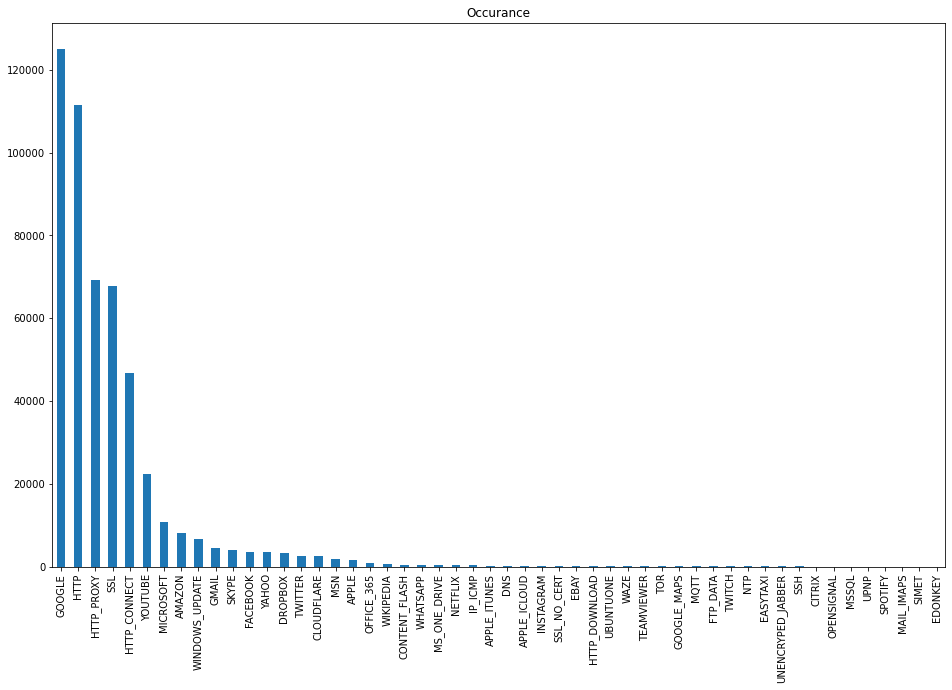

In [11]:
# Plot the number of records for individual applications
target_count = df['ProtocolName'].value_counts()
plt.figure(figsize=(16,10))
target_count.plot(kind='bar', title='Occurance');

In [12]:
# Removal of the applications saved in feats_toDelete var because they occur in a small amount of records and do not have a major impact on the model
df = df[~df.ProtocolName.isin(feats_toDelete)]

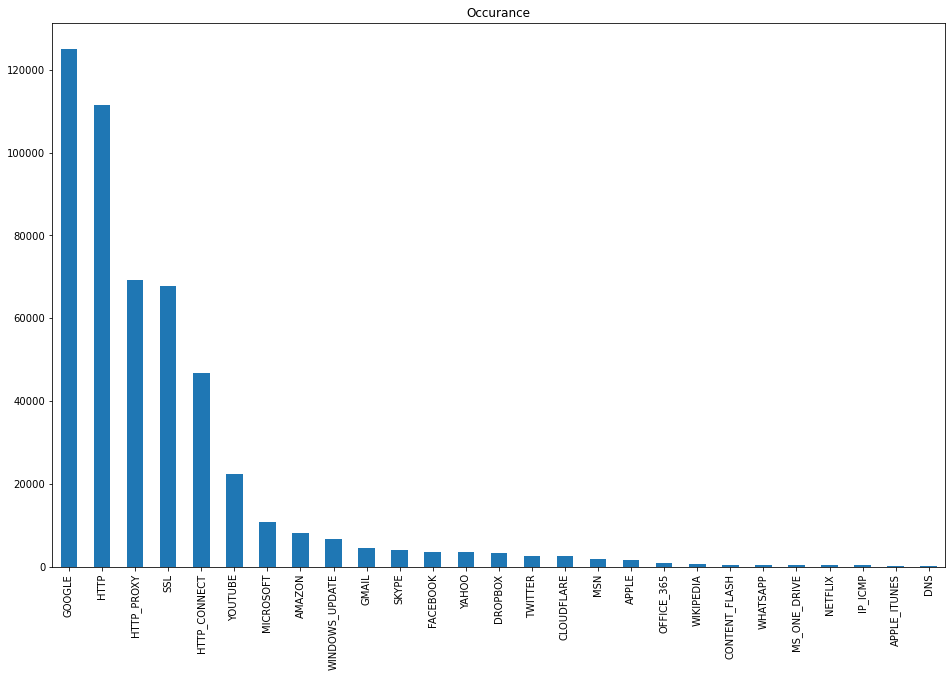

In [13]:
# Plot the number of records for individual applications one more time after some application removal
target_count2 = df['ProtocolName'].value_counts()
plt.figure(figsize=(16,10))
target_count2.plot(kind='bar', title='Occurance');

In [14]:
feats = [x for x in df.columns if (x != 'ProtocolName' and x != 'Flow.ID' and x != 'Timestamp' and x != 'Label')]
X = df[feats].astype(float)
Y = df['ProtocolName']

In [15]:
# Convert application names to numbers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

In [16]:
print(sorted(Counter(Y).items()))

[('AMAZON', 8099), ('APPLE', 1567), ('APPLE_ITUNES', 209), ('CLOUDFLARE', 2505), ('CONTENT_FLASH', 433), ('DNS', 189), ('DROPBOX', 3247), ('FACEBOOK', 3588), ('GMAIL', 4456), ('GOOGLE', 125059), ('HTTP', 111493), ('HTTP_CONNECT', 46807), ('HTTP_PROXY', 69216), ('IP_ICMP', 259), ('MICROSOFT', 10693), ('MSN', 1842), ('MS_ONE_DRIVE', 393), ('NETFLIX', 374), ('OFFICE_365', 738), ('SKYPE', 3916), ('SSL', 67804), ('TWITTER', 2635), ('WHATSAPP', 408), ('WIKIPEDIA', 546), ('WINDOWS_UPDATE', 6683), ('YAHOO', 3462), ('YOUTUBE', 22297)]


In [17]:
print(sorted(Counter(encoded_Y).items()))

[(0, 8099), (1, 1567), (2, 209), (3, 2505), (4, 433), (5, 189), (6, 3247), (7, 3588), (8, 4456), (9, 125059), (10, 111493), (11, 46807), (12, 69216), (13, 259), (14, 10693), (15, 1842), (16, 393), (17, 374), (18, 738), (19, 3916), (20, 67804), (21, 2635), (22, 408), (23, 546), (24, 6683), (25, 3462), (26, 22297)]


In [18]:
dict_nearMiss = {
"GOOGLE":            10000,
"HTTP":              10000,
"HTTP_PROXY":        10000,
"SSL":               10000,
"HTTP_CONNECT":      10000,
"YOUTUBE":           10000,
"AMAZON":             10000,
"MICROSOFT":          10000,
"GMAIL":              10000,
"WINDOWS_UPDATE":     10000,
"SKYPE":              10000,
"FACEBOOK":           10000,
"DROPBOX":            10000,
"YAHOO":              10000,
"TWITTER":            10000,
"CLOUDFLARE":         10000,
"MSN":                10000,
}

In [19]:
dict_smote = { "CONTENT_FLASH":       10000,
"APPLE":               10000,
"OFFICE_365":        10000,
"WHATSAPP":            10000,
"INSTAGRAM":          10000,
"WIKIPEDIA":           10000,
"MS_ONE_DRIVE":        10000,
"DNS":                 10000,
"IP_ICMP":             10000,
"NETFLIX":             10000,
"APPLE_ITUNES":        10000,
"SPOTIFY":             10000,
"APPLE_ICLOUD":        10000,
"EBAY":               10000,
"SSL_NO_CERT":          10000,
"GOOGLE_MAPS":          10000,
"EASYTAXI":             10000,
"TEAMVIEWER":           10000,
"HTTP_DOWNLOAD":        10000,
"MQTT":                 10000,
"TOR":                  10000,
"FTP_DATA":             10000,
"UBUNTUONE":            10000,
"NTP":                  10000,
"SSH": 10000}
print(dict_smote)

{'CONTENT_FLASH': 10000, 'APPLE': 10000, 'OFFICE_365': 10000, 'WHATSAPP': 10000, 'INSTAGRAM': 10000, 'WIKIPEDIA': 10000, 'MS_ONE_DRIVE': 10000, 'DNS': 10000, 'IP_ICMP': 10000, 'NETFLIX': 10000, 'APPLE_ITUNES': 10000, 'SPOTIFY': 10000, 'APPLE_ICLOUD': 10000, 'EBAY': 10000, 'SSL_NO_CERT': 10000, 'GOOGLE_MAPS': 10000, 'EASYTAXI': 10000, 'TEAMVIEWER': 10000, 'HTTP_DOWNLOAD': 10000, 'MQTT': 10000, 'TOR': 10000, 'FTP_DATA': 10000, 'UBUNTUONE': 10000, 'NTP': 10000, 'SSH': 10000}


In [20]:
# getting rid of the problem of unbalanced data set
pipe = make_pipeline(
    SMOTE(sampling_strategy=dict_smote),
    NearMiss(sampling_strategy=dict_nearMiss)
)

In [21]:
# check that all keys in sampling_strategy are also in y
X_resampled, y_resampled = (X, Y)

In [22]:
print("Shape pierwotnego pliku " + str(df.shape))
print("Shape X " + str(X.shape))
print("Shape X_resampled" + str(X_resampled.shape))
print("Shape Y " + str(Y.shape))
print("Shape y_resampled" + str(y_resampled.shape))

Shape pierwotnego pliku (498918, 87)
Shape X (498918, 83)
Shape X_resampled(498918, 83)
Shape Y (498918,)
Shape y_resampled(498918,)


In [23]:
# creating new dataset
new_dataframe = pd.DataFrame(data = X_resampled, columns = feats)

In [24]:
new_dataframe['ProtocolName'] = y_resampled

In [25]:
new_dataframe.describe()

,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets,...,min_seg_size_forward,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,L7Protocol
count,4.989180e+05,498918.000000,4.989180e+05,498918.000000,498918.000000,4.989180e+05,498918.000000,498918.000000,4.989180e+05,4.989180e+05,...,498918.000000,4.989180e+05,4.989180e+05,4.989180e+05,4.989180e+05,4.989180e+05,4.989180e+05,4.989180e+05,4.989180e+05,498918.000000
mean,1.294520e+09,37645.836917,1.594729e+09,10851.554412,6.004125,2.042573e+07,53.915499,63.890986,3.225316e+04,1.087518e+05,...,26.201773,2.623767e+05,1.402083e+05,4.307782e+05,1.620946e+05,6.842317e+06,1.059232e+06,7.770179e+06,5.865060e+06,98.503335
std,1.452503e+09,21840.175147,1.393200e+09,19676.239562,0.314518,3.635861e+07,887.895593,1458.414300,1.388558e+06,3.460063e+06,...,6.031146,2.248741e+06,1.082715e+06,2.933065e+06,2.044627e+06,1.585914e+07,4.324042e+06,1.747357e+07,1.487599e+07,53.893455
min,9.393201e+07,0.000000,6.817647e+07,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000
25%,1.808813e+08,3818.000000,1.808812e+08,443.000000,6.000000,6.840000e+02,2.000000,1.000000,6.000000e+00,0.000000e+00,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,91.000000
50%,1.808814e+08,48610.000000,1.145287e+09,3128.000000,6.000000,3.506545e+05,6.000000,4.000000,3.430000e+02,1.430000e+02,...,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,126.000000
75%,3.232244e+09,53880.000000,3.003188e+09,3128.000000,6.000000,1.779128e+07,15.000000,15.000000,1.776000e+03,4.502000e+03,...,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,130.000000
max,3.645130e+09,65534.000000,3.706970e+09,65534.000000,17.000000,1.200000e+08,268376.000000,542196.000000,5.006735e+08,1.345796e+09,...,48.000000,1.138933e+08,6.989470e+07,1.138933e+08,1.138933e+08,1.199973e+08,7.437682e+07,1.199973e+08,1.199973e+08,221.000000


In [26]:
#extract the file
new_dataframe.to_csv('KaggleImbalanced.csv', index=False)